<a href="https://colab.research.google.com/github/tobwalker/project_afmd_linkAnalysis/blob/main/AFMD_PageRank_Tobias_Walker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Link-Analysis of Amazon Products Based on Reviews ##

---

This code performs a link analysis of amazon products. A link is created if 2 products are reviewed by the same customer. The links are non-directional, which means in this context that they are always bidirectional. This Property ensures that deadends and spider traps cannot exist, because if there is a link in there is always also a link out. Nonetheless the network that is build might have a problem with islands, meaning not every product is necessarily connected with each other product.

---

**Example:**

Customer A reviewed Products 1,2 and 3. Therefore the following links exist:

```
[(1,2), (2,1), (1,3), (3,1), (2,3), (3,2)]
```








### Step 1: Configuring PySpark and import necessary packages ###

In [ ]:
# Spark config
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz
!pip install pyspark
!pip install findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--driver-memory 9g pyspark-shell"
import findspark
findspark.init("spark-3.4.0-bin-hadoop3")
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
import pyspark
sc = spark.sparkContext
spark = SparkSession.builder.appName("AlgoForBigData").getOrCreate()
# Packages
from pyspark.sql import functions as F
from pyspark.sql.functions import broadcast, col, count, explode, lit, monotonically_increasing_id, approx_count_distinct, expr, desc, asc
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import ArrayType, StringType, StructType, StructField
from itertools import combinations
from functools import reduce
import glob
import zipfile
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=31fd8e0b6635bb59e708fa29c1a13d122ca76ab703a01f6a7ec2079f2c96fa5e
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


### Step 2: Download and import dataset ###

Downloads the Amazon review dataset from KAGGLE, but only extracts the dataset 'Automotive', which is then imported into a PySpark DataFrame.


In [ ]:
# Download dataset from Kaggle
os.environ['KAGGLE_USERNAME'] = "xxxxx"
os.environ['KAGGLE_KEY'] = "xxxxx"
!kaggle datasets download -d cynthiarempel/amazon-us-customer-reviews-dataset

# Unzip only the automotive dataset
zip_path = "/content/amazon-us-customer-reviews-dataset.zip"
extract_path = "/content/amazon/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = [name for name in zip_ref.namelist() if "Automotive" in name]
    zip_ref.extractall(path=extract_path, members=file_list)

# Print the extracted file list
for file_name in file_list:
  print(f"Extracted files: {os.path.join(extract_path, file_name)}")

100% 20.9G/21.0G [04:14<00:00, 137MB/s]
100% 21.0G/21.0G [04:14<00:00, 88.4MB/s]
Extracted files: /content/amazon/amazon_reviews_us_Automotive_v1_00.tsv


In [ ]:
# Import Dataset
def import_and_clean_datasets(file_paths):
    datasets = [spark.read.csv(file_path, sep='\t', header=True, inferSchema=True).select(['customer_id', 'product_id']) for file_path in file_paths]
    # Concatenate datasets and remove duplicates
    concatenated_data = reduce(lambda df1, df2: df1.unionAll(df2), datasets).dropDuplicates()
    # Only keeping customers with at least 2 reviews
    customer_reviews_count = concatenated_data.groupby('customer_id').count().withColumnRenamed('count', 'review_count')
    concatenated_data = concatenated_data.join(broadcast(customer_reviews_count), 'customer_id').filter(customer_reviews_count['review_count'] > 1).drop('review_count')
    # Approximate number of unique products in the dataset
    unique_products = concatenated_data.select(approx_count_distinct('product_id')).first()[0]
    print(f"Approximate number of products in the dataset: {unique_products}")
    print(f"Number of reviews: {concatenated_data.count()}")
    # Return dataframe and number of products
    return concatenated_data

# Perform import function
file_paths = glob.glob("/content/amazon/*")
reviews = import_and_clean_datasets(file_paths)

Approximate number of products in the dataset: 554647
Number of reviews: 2178740


### Step 3: Build the product links ###

In [ ]:
# Function that builds the combinations (including reversed) from a list
def generate_product_pairs(products):
    pairs = [(p1, p2) for p1, p2 in combinations(products, 2)]
    reversed_pairs = [(p2, p1) for p1, p2 in pairs]
    return pairs + reversed_pairs
# Function that builds the links based on the dataframe
def construct_product_links(review_df):
    generate_product_pairs_udf = F.udf(generate_product_pairs, ArrayType(StructType([
        StructField('product_1', StringType()),
        StructField('product_2', StringType())
    ])))
    # Group dataframe over customer_id: generates list of all products that are reviewed by the customer
    review_grouped_df = review_df.groupby('customer_id').agg(F.collect_set('product_id').alias('product_ids'))
    # Generate product pairs
    links_df = review_grouped_df.withColumn('product_pairs', generate_product_pairs_udf('product_ids')).select(explode('product_pairs').alias('product_pair'))
    # Reformat dataframe
    links_df = links_df.select(col("product_pair.product_1").alias("product_1"), col("product_pair.product_2").alias("product_2"))
    # Number of links
    print(f"Number of links: {links_df.count()}")
    return links_df

# Perform link building fucntion on review dataset
links = construct_product_links(reviews)

Number of links: 15777272


### Step 4: Calculating the transition probabilities ###


In [ ]:
# Function that calculates the transition probability
def construct_connection_matrix(links):
    adjacency = links.groupBy('product_1').agg(expr('collect_list(product_2) as adjacency_list'))
    connection_matrix = adjacency.withColumn('transition_prob', expr('1.0 / size(adjacency_list)')).select(expr('explode(adjacency_list) as product_2'), 'product_1', 'transition_prob')
    return connection_matrix

# Perform the function on the links dataset
connection_matrix_df = construct_connection_matrix(links)
connection_matrix_df.show()

+----------+----------+---------------+
| product_2| product_1|transition_prob|
+----------+----------+---------------+
|B003YBMDRU|0715000322| 0.076923076923|
|B00K0VMXDQ|0715000322| 0.076923076923|
|B00042KG3A|0715000322| 0.076923076923|
|B002TTU96A|0715000322| 0.076923076923|
|B00AUFMHNI|0715000322| 0.076923076923|
|B000W4XS80|0715000322| 0.076923076923|
|B00ENAZA8A|0715000322| 0.076923076923|
|B004G3NW20|0715000322| 0.076923076923|
|B001P29P2Q|0715000322| 0.076923076923|
|B004IUMZ92|0715000322| 0.076923076923|
|B000K5SD68|0715000322| 0.076923076923|
|B003AU5KQ6|0715000322| 0.076923076923|
|B004ZGNCS2|0715000322| 0.076923076923|
|B007RHA5KE|0991557557| 0.111111111111|
|B001CJHU9W|0991557557| 0.111111111111|
|B000COS0H4|0991557557| 0.111111111111|
|B00ESMSOOU|0991557557| 0.111111111111|
|B000MDB6NK|0991557557| 0.111111111111|
|B001LX52OE|0991557557| 0.111111111111|
|B008M1WK7A|0991557557| 0.111111111111|
+----------+----------+---------------+
only showing top 20 rows



### Step 5: Initial PageRank dataframe ###

Because the count of unique products is just approximated, the column with the PageRank might not add up to exactly 1.

In [ ]:
# Function that generates the initial PageRank dataframe - Requires number of unique products
def initial_pagrank(connection_matrix):
    # Number of uique products
    unique_products = connection_matrix.select(approx_count_distinct('product_1')).first()[0]
    print(f"number of unique products in connection matrix: {unique_products}")
    # Initial PageRank value
    init_page_rank = (1.0 / unique_products)
    # Dataframe with unique products
    page_rank_df = connection_matrix.select('product_1').distinct().withColumn('page_rank', lit(init_page_rank))
    page_rank_df = page_rank_df.withColumnRenamed('product_1', 'product')
    return page_rank_df
# Perform the function
pagerank = initial_pagrank(connection_matrix=connection_matrix_df)

number of unique products in connection matrix: 554647


### Step 6: Calculate the PageRank ###

In [ ]:
# PageRank calculation
tolerance = 1.97e-09
def pagerank_calculation(page_rank_df, tolerance, max_iter=50, prior_rank_diff=50000):
    # Set up variables
    iteration = 1
    list_of_distance = []
    # While the number of iterations is lower then the set maximum
    while iteration < max_iter:
        # Sort PageRank df
        sorted_page_rank_df = page_rank_df.orderBy('product')
        # Calculate PageRank
        new_page_rank_df = (connection_matrix_df
            .join(page_rank_df, connection_matrix_df.product_1 == page_rank_df.product)
            .withColumn('partial_rank', (col('page_rank') * col('transition_prob')).cast('double'))  # Convert partial_rank to double
            .groupBy(connection_matrix_df.product_2)
            .agg(F.sum('partial_rank').alias('new_page_rank')))
        # Measure distance between new and old pagerank
        rank_diff = (new_page_rank_df
            .join(page_rank_df, new_page_rank_df.product_2 == page_rank_df.product)
            .withColumn('rank_diff', F.abs((col('new_page_rank') - col('page_rank'))**2))
            .agg(F.sum('rank_diff').alias('total_rank_diff'))
            .collect()[0]['total_rank_diff'])
        print(f"iteration: {iteration}, rank_diff: {rank_diff}")
        list_of_distance.append(rank_diff)
        # Distance should be always decreasing and converging to zero
        if prior_rank_diff <= rank_diff:
            print("The distance didn't decrease!")
            return page_rank_df, iteration, list_of_distance
        prior_rank_diff = rank_diff
        # If distance smaller than set tolerance than break loop
        if rank_diff < tolerance:
            page_rank_df = new_page_rank_df.withColumnRenamed('new_page_rank', 'page_rank').withColumnRenamed('product_2', 'product')
            return page_rank_df, iteration, list_of_distance
        # Replace PageRank with new one and go into next iteration
        page_rank_df = new_page_rank_df.withColumnRenamed('new_page_rank', 'page_rank').withColumnRenamed('product_2', 'product')
        iteration += 1
    return page_rank_df, iteration, list_of_distance

# Perform funtion
final_pagerank, iteration, list_of_distance = pagerank_calculation(page_rank_df=pagerank,
                                                                   tolerance=tolerance)
#page_rank_df.show()


iteration: 1, rank_diff: 1.7618319919367947e-05
iteration: 2, rank_diff: 1.1917040900158249e-06
iteration: 3, rank_diff: 1.7331924805989104e-07
iteration: 4, rank_diff: 7.839117490036606e-08
iteration: 5, rank_diff: 3.282840796370291e-08
iteration: 6, rank_diff: 1.7214629665672145e-08
iteration: 7, rank_diff: 9.613347833939111e-09
iteration: 8, rank_diff: 6.145344061168716e-09
iteration: 9, rank_diff: 4.268991910900526e-09
iteration: 10, rank_diff: 3.32596475687785e-09
iteration: 11, rank_diff: 2.761514344829262e-09
iteration: 12, rank_diff: 2.4657677579320892e-09
iteration: 13, rank_diff: 2.271323940599893e-09
iteration: 14, rank_diff: 2.168219093690374e-09
iteration: 15, rank_diff: 2.0936301945889633e-09
iteration: 16, rank_diff: 2.054491579285324e-09
iteration: 17, rank_diff: 2.023055965114051e-09
iteration: 18, rank_diff: 2.007047935803977e-09
iteration: 19, rank_diff: 1.9925870008353572e-09
iteration: 20, rank_diff: 1.9855612988051077e-09
iteration: 21, rank_diff: 1.97833268830148

### Step 7: Analyse results ###

In [ ]:
# Number of iterations
print(f"The Loop terminated afer {iteration} iterations")

The Loop terminated afer 24 iterations


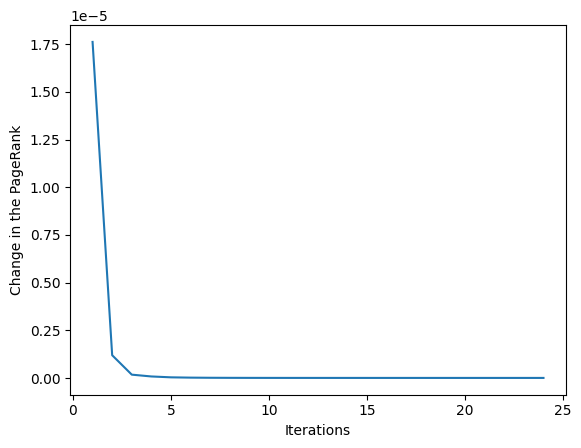

In [ ]:
# Development of the distance
def plot_distance(distance):
    x = range(1, len(distance) + 1)
    y = distance
    plt.plot(x, y)
    plt.xlabel('Iterations')
    plt.ylabel('Change in the PageRank')
    plt.show()

# Perform function
plot_distance(list_of_distance)

Initial PageRank: 1.8029485420456615e-06
Lowest PageRank: Row(product='B004XH6PQ4', page_rank=4.6628330620614004e-08)


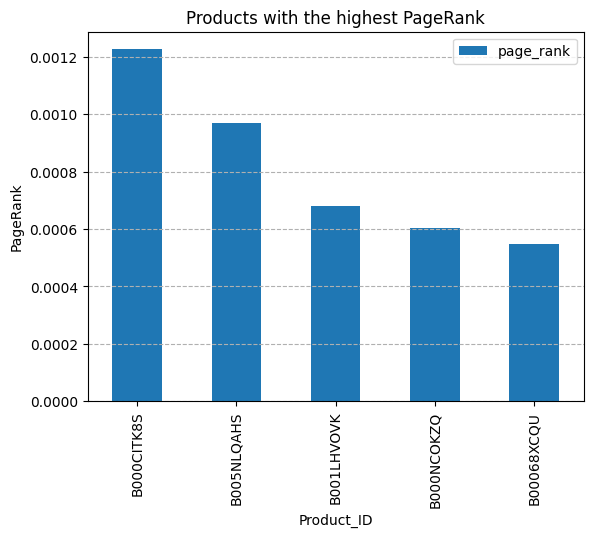

In [ ]:
# PageRank Analysis
def pagerank_analysis(pagerank_df, unique_products):
    # initial PageRank
    print(f"Initial PageRank: {1.0 / unique_products}")
    # Row with the lowest PageRank
    lowest_pagerank_row = pagerank_df.orderBy(asc("page_rank")).first()
    print(f"Lowest PageRank: {lowest_pagerank_row}")
    # Retrieve rows with highest PageRanks
    top_5_rows = pagerank_df.orderBy(desc("page_rank")).limit(5)
    top_5_pd = top_5_rows.toPandas()
    # Plot highest PageRanks
    top_5_pd.sort_values("page_rank", ascending=False).plot.bar(x='product', y='page_rank')
    plt.title('Products with the highest PageRank')
    plt.xlabel('Product_ID')
    plt.ylabel('PageRank')
    plt.grid(axis='y', linestyle='--')
    plt.show()

# Execute function
pagerank_analysis(pagerank_df=final_pagerank,
                  unique_products=count_unique_products)